# Boston Housing

Criaremos modelos preditivos para o setor imobiliário utilizando [_The Boston Housing Dataset_](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html).

Para a conclusão do trabalho, é importante que ele tenha:
1. **Descrição dos dados**;
2. **Divisão dos dados** em treino e teste;
3. **Visualização dos dados**;
4. **Preparação dos dados**;
5. **Comparação de pelo menos 3 modelos de machine learning**, com ajustes de hiperparâmetros e justificativa da escolha do melhor;
6. **Justificativa da métrica escolhida**;
7. **Discussão da técnica de validação** e explicação de como o modelo evita *snooping bias/data leakage*;
8. **Teste final** para obter o erro aproximado.


## Configuração inicial

Nesta etapa, vamos configurar o ambiente de trabalho importando as bibliotecas necessárias para manipulação de dados:

- **Numpy**: realizar cálculos e trabalhar com arrays;
- **matplotlib**: criar gráficos e visualizações.

In [2]:
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

Além disso, é importante fixarmos a _seed_ para que os resultados sejam reprodutíveis.

In [3]:
seed = 42
np.random.seed(seed)

## Obtenção do conjunto de dados

Nesta seção, vamos carregar o conjunto de dados **Boston Housing**. Este conjunto de dados contém informações coletadas pelo _U.S Census Service_ sobre moradia na área de Boston, Massachusetts.

Note que a [URL](http://lib.stat.cmu.edu/datasets/boston) contém uma breve descrição do conjunto de dados. Além disso, os dados não estão bem formatados: as informações de cada casa estão distribuídas em 2 linhas. Precisamos levar isso em consideração ao importar os dados, reorganizando as linhas de modo que cada uma contenha todas as informações relevantes para cada imóvel.

Abaixo, fazemos isso ao carregar os dados, ajustando a formatação.

In [4]:
import pandas as pd

data_url = "http://lib.stat.cmu.edu/datasets/boston"

raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
housing_ar = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

Precisamos ainda nomear as colunas e transformar `housing_ar` em um `DataFrame`.

In [5]:
housing = pd.DataFrame(housing_ar, columns=['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT'])
housing['MEDV'] = target

## Descrição do conjunto

As colunas do conjunto são:

- **CRIM**: Taxa de criminalidade per capita por cidade.
- **ZN**: Proporção de zonas residenciais por lotes acima de 25.000 pés quadrados.
- **INDUS**: Proporção de áreas (acres) não comerciais (negócios) por cidade.
- **CHAS**: Variável fictícia que indica se a casa está próxima ao rio Charles (1) ou não (0).
- **NOX**: Concentração de óxidos nítricos (em partes por 10 milhões).
- **RM**: Número médio de cômodos por moradia.
- **AGE**: Proporção de casas ocupadas construídas antes de 1940.
- **DIS**: Distância ponderada entre a residência e 5 centros de emprego de Boston.
- **RAD**: Índice de acessibilidade a rodovias radiais.
- **TAX**: Valor total da taxa de imposto sobre propriedade por 10000 dólares.
- **PTRATIO**: Proporção aluno-professor por cidade.
- **B**: 1000(Bk - 0,63)^2 onde Bk é a proporção de negros por cidade.
- **LSTAT**: Percentual da população que é de "baixo status".
- **MEDV**: Preço médio das casas (em milhares de dólares).


Iremos visualizar as 5 primeiras linhas do dataset.

In [6]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Aparentemente, as linhas seguem uma ordem: `CHAS = 0` para todos as 5 linhas; `RAD` é sequencial; `ZN = 0` para 4 das 5 linhas.

Além disso, todos os dados são numéricos. Podemos tratar `CHAS` como um booleano também.

Vejamos também que todas as entradas da tabela possuem valores.

In [7]:
print('Há entradas vazias:',housing.isnull().any().any())

Há entradas vazias: False


Para obter uma visão geral das características do conjunto , utilizamos o método `describe()`, que fornece estatísticas descritivas das colunas numéricas:


In [8]:
housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


A seguir, apresentamos os histogramas.

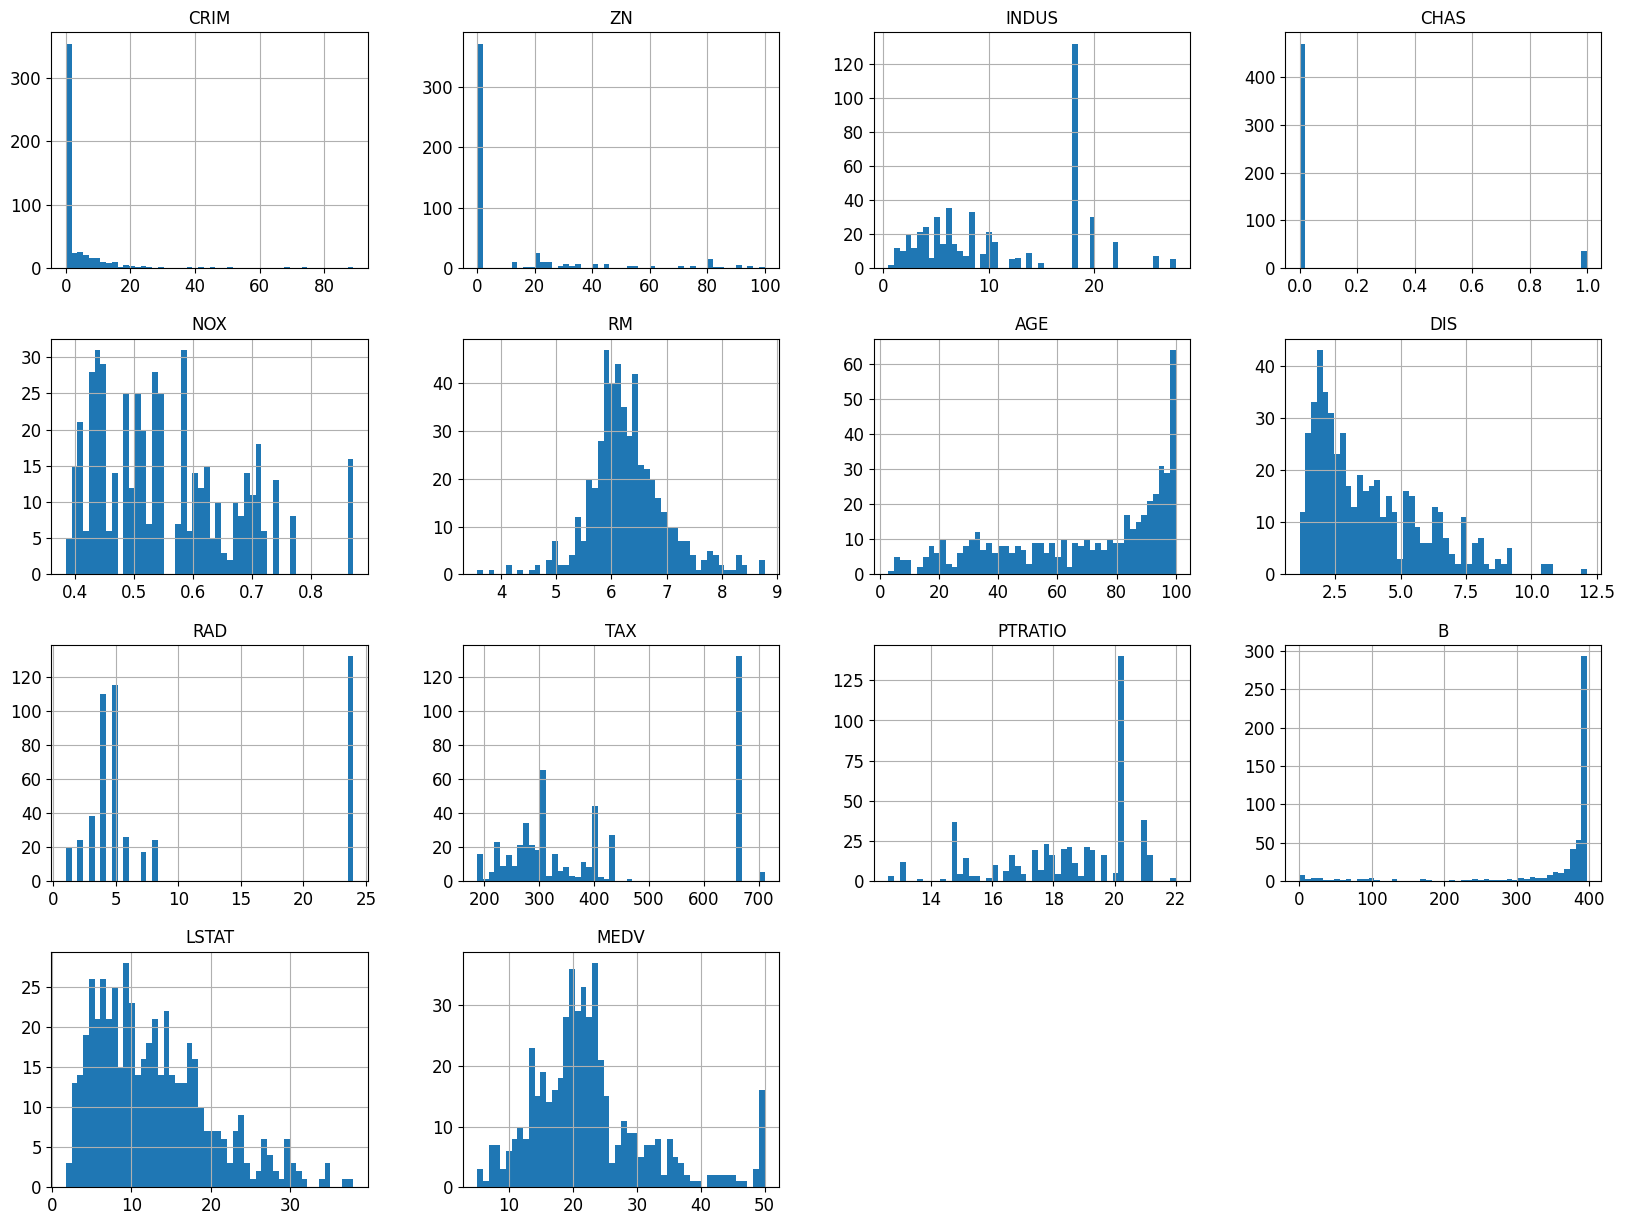

In [9]:
housing.hist(bins=50, figsize=(20,15))
plt.show()

**Observação 1**

Esse conjunto de dados possui um problema ético significativo. Ao tentar utilizar o método `load_boston` da biblioteca `scikit-learn`, recebemos o seguinte aviso:

> The Boston housing prices dataset has an ethical problem: as investigated in [1], the authors of this dataset engineered a non-invertible variable "B" assuming that racial self-segregation had a positive impact on house prices [2]. Furthermore the goal of the research that led to the creation of this dataset was to study the impact of air quality but it did not give adequate demonstration of the validity of this assumption.

> [1] M Carlisle.
"Racist data destruction?"
<https://medium.com/@docintangible/racist-data-destruction-113e3eff54a8>

> [2] Harrison Jr, David, and Daniel L. Rubinfeld.
"Hedonic housing prices and the demand for clean air."
Journal of environmental economics and management 5.1 (1978): 81-102.
<https://www.researchgate.net/publication/4974606_Hedonic_housing_prices_and_the_demand_for_clean_air>

Basicamente, os autores criaram a coluna não-inversível **B**, assumindo que a auto-segregação racial tinha um impacto positivo nos preços das casas. Além disso, a pesquisa que levou à criação deste conjunto de dados pretendia analisar o impacto da qualidade do ar, mas não conseguiu demonstrar essa ideia de forma adequada.








**Observação 2**

Como dito [aqui](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html), a variável **MEDV** parece estar limitada em 50. Essa limitação é indicada pelo fato de que o maior preço médio reportado é exatamente \$50.000 em 16 casos, enquanto 15 casos apresentam preços entre \$40.000 e \$50.000. Porém, os autores da pesquisa não fazem menção a essa limitação.












